# ASSIGNMENT 2A - Detecting Linux system hacking activities
#### Name: Mudit Sharma
#### Student ID: 30340071

In [1]:
import os

os.environ['PYSPARK_PYTHON'] = '/Users/muditsharma/opt/anaconda3/bin/python3.8'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/Users/muditsharma/opt/anaconda3/bin/python3.8'
os.environ['JAVA_HOME'] = '/Library/Internet Plug-Ins/JavaAppletPlugin.plugin/Contents/Home'

In [69]:
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col, desc
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import pandas as pd

# 1 - Data Preparation & Exploration
## 1.1 - Creating SparkSession

In [3]:
# Import SparkConf class into program
from pyspark import SparkConf
from pyspark.sql import SparkSession # Spark SQL

# Setup configuration parameters for Spark
master = "local[1]"
app_name = "Week 5"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

conf = spark.sparkContext._conf.setAll([('spark.sql.files.maxPartitionBytes', '32MB')])
spark.sparkContext.stop()
spark = SparkSession.builder.config(conf=conf).getOrCreate()

conf = spark.sparkContext._conf.setAll([('spark.sql.files.maxPartitionBytes', '32MB')])

## 1.2 - Loading the Data
## 1.2.1

In [4]:
# Define a schema for the import of the Process file
schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("TRUN", IntegerType()),
    StructField("TSLPI", IntegerType()),
    StructField("TSLPU", IntegerType()),
    StructField("POLI", StringType()),
    StructField("NICE", IntegerType()),
    StructField("PRI", IntegerType()),
    StructField("RTPR", IntegerType()),
    StructField("CPUNR", IntegerType()),
    StructField("Status", StringType()),
    StructField("EXC", IntegerType()),
    StructField("State", StringType()),
    StructField("CPU", DoubleType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType())
])

Process1 = spark.read.csv("linux_process_1.csv",header=True,schema=schema)
Process2 = spark.read.csv("linux_process_2.csv",header=True,schema=schema)

Process = Process1.union(Process2)

# Cache the file as required
Process.cache()

# Verify the import has gone according to our requirements
print(type(Process))
print('Number of Partitions: ',Process.rdd.getNumPartitions())
print('Number of Rows: ',Process.count())

<class 'pyspark.sql.dataframe.DataFrame'>
Number of Partitions:  4
Number of Rows:  1927968


In [5]:
# Define a schema for the import of the Memory file
schema = StructType([
    StructField("ts", IntegerType()),
    StructField("PID", IntegerType()),
    StructField("MINFLT", StringType()),
    StructField("MAJFLT", StringType()),
    StructField("VSTEXT", StringType()),
    StructField("VSIZE", DoubleType()),
    StructField("RSIZE", StringType()),
    StructField("VGROW", StringType()),
    StructField("RGROW", StringType()),
    StructField("MEM", DoubleType()),
    StructField("CMD", StringType()),
    StructField("attack", IntegerType()),
    StructField("type", StringType())
])

Memory1 = spark.read.csv("linux_memory_1.csv",header=True,schema=schema)
Memory2 = spark.read.csv("linux_memory_2.csv",header=True,schema=schema)

Memory = Memory1.union(Memory2)

# Cache the file as required
Memory.cache()

# Verify the import has gone according to our requirements
print(type(Memory))
print('Number of Partitions: ',Memory.rdd.getNumPartitions())
print('Number of Rows: ',Memory.count())

<class 'pyspark.sql.dataframe.DataFrame'>
Number of Partitions:  4
Number of Rows:  2000000


## 1.2.2

In [6]:
# Check for NULL, and NaN values in both Dataframes
Process.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Process.columns]).show()
Memory.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Memory.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [7]:
dictionary = {'M':1000000,'K':1000}

# Define a function to help fix dirty data
def valueFixer (value):
    
    # If the value is something like '318 6'
    value = str(value).replace(' ','') 
    
    # If the value is M or K
    if value in dictionary.keys(): 
        return dictionary[value]
    
    # If the value is an integer, e.g '32'
    elif value.isnumeric(): 
        return int(value)
    
    # If the value uses shorthand, e.g 324K (=324,000)
    elif value[-1].isalpha():
        return (float(value[:-1])*dictionary[value[-1]])
    
    # If the value is negative (this is the last option as all other irregualrities in the data would have been rectified above)
    else:
        return float(value)   

In [8]:
# Convert the function into a UDF
valueFixerUDF = udf(lambda x: valueFixer(x))

In [9]:
# Apply the UDF to affected columns
schemaDictionary = {'MINFLT':IntegerType(),
                    'MAJFLT':DoubleType(),
                    'VSTEXT':DoubleType(),
                    'RSIZE':DoubleType(),
                    'VGROW':DoubleType(),
                    'RGROW':DoubleType()}

for column in ['MINFLT','MAJFLT','VSTEXT','RSIZE','VGROW','RGROW']:
    
    # Fix the values themselves
    Memory = Memory.withColumn(column,valueFixerUDF(column))
    
    # Cast the columns into the appropriate data types
    Memory = Memory.withColumn(column,col(column).cast(schemaDictionary[column]))

In [10]:
# Verify that everything has gone according to our requirements
Memory.printSchema()

root
 |-- ts: integer (nullable = true)
 |-- PID: integer (nullable = true)
 |-- MINFLT: integer (nullable = true)
 |-- MAJFLT: double (nullable = true)
 |-- VSTEXT: double (nullable = true)
 |-- VSIZE: double (nullable = true)
 |-- RSIZE: double (nullable = true)
 |-- VGROW: double (nullable = true)
 |-- RGROW: double (nullable = true)
 |-- MEM: double (nullable = true)
 |-- CMD: string (nullable = true)
 |-- attack: integer (nullable = true)
 |-- type: string (nullable = true)



In [11]:
# Again, verify that there are no NaN or NULL values, which would indicate inadequacies in the UDF
Memory.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in Memory.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



## 1.3 - Exploring the Data
## 1.3.1

In [12]:
# Count the number of rows where attack=0, attack=1 in both Dataframes

MAttack1Count = Memory\
.filter(col('attack')==1)\
.count()

MAttack0Count = Memory\
.filter(col('attack')==0)\
.count()

PAttack1Count = Process\
.filter(col('attack')==1)\
.count()

PAttack0Count = Process\
.filter(col('attack')==0)\
.count()

In [13]:
# Repeat the above, but now also grouping by 'type' for each Dataframe, and including a percentage

print ('MEMORY')
print ('Attacks: ',MAttack1Count, 'of', Memory.count())
print ('Non-Attacks: ',MAttack0Count, 'of', Memory.count())

MAttack = Memory\
.groupBy('attack','type')\
.count()\
.orderBy('attack')

MAttack01 = MAttack\
.withColumn('Percentage',100*MAttack['count']/Memory.count())\
.orderBy(MAttack['count'].desc())\
.show()

print ('PROCESS')
print ('Attacks: ',PAttack1Count, 'of', Process.count())
print ('Non-Attacks: ',PAttack0Count, 'of', Process.count())

PAttack = Process\
.groupBy('attack','type')\
.count()\
.orderBy('attack')

PAttack01 = PAttack\
.withColumn('Percentage',100*PAttack['count']/Process.count())\
.orderBy(PAttack['count'].desc())\
.show()

MEMORY
Attacks:  205623 of 2000000
Non-Attacks:  1794377 of 2000000
+------+---------+-------+----------+
|attack|     type|  count|Percentage|
+------+---------+-------+----------+
|     0|   normal|1794377|  89.71885|
|     1|      dos|  75283|   3.76415|
|     1|injection|  58523|   2.92615|
|     1|     ddos|  45689|   2.28445|
|     1| password|  26016|    1.3008|
|     1|     mitm|    112|    0.0056|
+------+---------+-------+----------+

PROCESS
Attacks:  291364 of 1927968
Non-Attacks:  1636604 of 1927968
+------+---------+-------+--------------------+
|attack|     type|  count|          Percentage|
+------+---------+-------+--------------------+
|     0|   normal|1636604|   84.88750850636525|
|     1|     ddos|  71603|  3.7139101893807367|
|     1|      dos|  70721|  3.6681625421168818|
|     1| password|  51409|  2.6664861657454897|
|     1|injection|  41311|   2.142722285847068|
|     1| scanning|  38449|  1.9942758386031303|
|     1|      xss|  17759|  0.9211252468920647|
| 

Here, we can make the following observations:
- ~90% of records from Memory, and ~85% of records from Process represent non-attacks

Within Memory:
- The following attack types (DOS, Injection, and DDOS) occur between ~1 and ~4% of the time
- Password and MITM attacks represent a very low percentage of attacks, occuring ~0.005% of the time

Within Process:
- The following attack types (DDOS, DOS, Injection, Scanning, and XSS) occur between ~1 and ~4% of the time
- Password and MITM attacks represent a very low percentage of attacks, occuring ~0.005% of the time

To get a clearer picture of the distribution of the different types of attacks, we can filter out non-attacks:

In [14]:
# Same as above, just with greater granularity into attack types
# This was achieved by simply not considering rows where attack=0

MAttack1Count = Memory\
.filter(col('attack')==1)\
.count()

MAttack1 = Memory\
.filter(col('attack')==1)\
.groupBy('attack','type')\
.count()

MAttack1\
.withColumn('Percentage',100*MAttack1['count']/MAttack0Count)\
.orderBy(MAttack1['count'].desc())\
.show()

PAttack1Count = Process\
.filter(col('attack')==1)\
.count()

PAttack1 = Process\
.filter(col('attack')==1)\
.groupBy('attack','type')\
.count()

PAttack1\
.withColumn('Percentage',100*PAttack1['count']/PAttack0Count)\
.orderBy(PAttack1['count'].desc())\
.show()

+------+---------+-----+--------------------+
|attack|     type|count|          Percentage|
+------+---------+-----+--------------------+
|     1|      dos|75283|   4.195495149570018|
|     1|injection|58523|   3.261466235913635|
|     1|     ddos|45689|  2.5462319233917956|
|     1| password|26016|  1.4498625428212688|
|     1|     mitm|  112|0.006241720664052203|
+------+---------+-----+--------------------+

+------+---------+-----+--------------------+
|attack|     type|count|          Percentage|
+------+---------+-----+--------------------+
|     1|     ddos|71603|   4.375096235864021|
|     1|      dos|70721|   4.321204152012338|
|     1| password|51409|   3.141199703776845|
|     1|injection|41311|   2.524190335597371|
|     1| scanning|38449|   2.349316022690889|
|     1|      xss|17759|  1.0851128312041276|
|     1|     mitm|  112|0.006843439219261348|
+------+---------+-----+--------------------+



We continue to observe that Password and MITM attacks constitute smaller percentages of the overall attacks that take place. However, MITM attacks continue to represent a very small minority, still occuring ~0.05% of the time at most.

## 1.3.2

In [15]:
# Separate numeric from non-numeric columns for summary statistics

MnumericColumns = [column for column in Memory.columns if Memory.select(column).dtypes[0][1] != 'string']
MstringColumns = [column for column in Memory.columns if Memory.select(column).dtypes[0][1] == 'string' and column not in ['attack','type']]

PnumericColumns = [column for column in Process.columns if Process.select(column).dtypes[0][1] != 'string']
PstringColumns = [column for column in Process.columns if Process.select(column).dtypes[0][1] == 'string' and column not in ['attack','type']]

In [16]:
Memory.select(MnumericColumns).describe().toPandas().drop(['attack'],axis=1)

,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM
0,count,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000
1,mean,1.55624581707609E9,4999.360446,983.344344,987846.5873270865,46453.27415208986,4496.419966448754,23722.888664201997,984.4668735599994,483.17466255,0.003385165000001682
2,stddev,984463.3682899196,4887.313351921473,19229.610980642334,1.4842874238098994E7,658730.2051543018,9046.338093399043,1986383.180873521,86174.82585202329,1491.4761059171788,0.010943425779985876
3,min,1554216855,1007,0,0.0,0.0,0.0,-9728.0,-9392000.0,0.0,0.0
4,max,1558355716,53096,8050000,2.244E8,1.12E7,88040.0,2.244E8,1.116E7,98920.0,0.44


In [17]:
Process.select(PnumericColumns).describe().toPandas().drop(['attack'],axis=1)

,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.02238527299209388
2,stddev,771350.0248109235,4987.784329320437,0.247825870904161,6.988459728531793,0.04421874419214597,8.40318986475207,22.624445062102893,0.0,1.5274047225903056,1.4619498567691878,0.13628943687184275
3,min,1554216855,1007,0,0,0,0,0,0,0,0,0.0
4,max,1557593017,53080,12,70,21,20,139,0,5,127,4.02


The values shown above seem mostly compatible with the descriptions in our provided metadata file, with the notable exception of `RTPR` in `Process`, which seems to be a column composed entirely of 0's. From the metadata file, we know:

- This column's value is supposed to range from 0 to 99
- It denotes a priority on the basis of `POLI`, the scheduling policy, which seems to be either `'norm'`, `'0'`, or `'-'`.
    - Since we don't know what `'0'` or `'-'` represent, it is difficult to ascertain whether the data in `RTPR` is accurate. 
    
In any case, when the features are encoded, it is likely that these will be converted into numerical factors. During that process, we are guaranteed to find that `RTPR` is a functionally useless variable, and can be ignored entirely. Since it only takes a value of `0`, it is incapable of adding to or detracting from any model we create.

We can verify this using the following `groupBy` method, confirming that while `RTPR` does not seem to be incompatible with its metadata and/or related columns, it is guaranteed to be excluded during model-building.

In [18]:
Process.groupBy('POLI','PRI',"RTPR").count().show()

+----+---+----+-------+
|POLI|PRI|RTPR|  count|
+----+---+----+-------+
|norm|120|   0|1394954|
|   0|  0|   0|  53216|
|norm|110|   0|     15|
|norm|130|   0|   1586|
|norm|109|   0|   6765|
|norm|100|   0| 441282|
|   -|  0|   0|  13194|
|norm|121|   0|  16840|
|norm|139|   0|    116|
+----+---+----+-------+



Another issue is that `NICE` in Process does not seem to naturally take a value between -20 to +19 as described in the metadata file, but the Ed Forum discussion located at https://edstem.org/courses/4542/discussion/307873?answer=714563 provides a solution, informing us that this value can be derived from the `PRI` column, which I have implemented as follows:

In [19]:
def NICEFixer (value):
    
    return(value-120)

In [20]:
NICEFixerUDF = udf(lambda x: NICEFixer(x))

In [21]:
Process = Process.withColumn('NICE',NICEFixerUDF('PRI'))

In [22]:
# Summary statistics for string columns
for column in MstringColumns:
    Memory\
    .select(column)\
    .groupBy(column)\
    .count()\
    .sort(desc('count'))\
    .show(10)

+----------+------+
|       CMD| count|
+----------+------+
|      atop|325985|
|   apache2| 89761|
| jfsCommit| 81714|
|  vmtoolsd| 77871|
|      Xorg| 49981|
|  nautilus| 48356|
|irqbalance| 44387|
|    compiz| 44356|
|  ostinato| 43024|
|     drone| 41392|
+----------+------+
only showing top 10 rows



In [23]:
# Summary statistics for string columns
for column in PstringColumns:
    Process\
    .select(column)\
    .groupBy(column)\
    .count()\
    .sort(desc('count'))\
    .show(10)

+----+-------+
|POLI|  count|
+----+-------+
|norm|1861558|
|   0|  53216|
|   -|  13194|
+----+-------+

+------+-------+
|Status|  count|
+------+-------+
|     -|1416322|
|     0| 438984|
|    NE|  48602|
|     N|  23313|
|    NS|    743|
|     C|      3|
|    NC|      1|
+------+-------+

+-----+-------+
|State|  count|
+-----+-------+
|    S|1676350|
|    I|  98986|
|    R|  84753|
|    E|  66410|
|    Z|   1118|
|    D|    344|
|    T|      7|
+-----+-------+

+--------------+------+
|           CMD| count|
+--------------+------+
|          atop|441180|
|       apache2|313143|
|      vmtoolsd|112029|
|          Xorg| 66813|
|      nautilus| 63449|
|gnome-terminal| 47628|
|        compiz| 44386|
|    irqbalance| 44324|
|      ostinato| 42979|
|         drone| 41390|
+--------------+------+
only showing top 10 rows



Here, we note that the `POLI`, and `Status` columns seem to contain `'-'`. In fact, 73% of the rows in Process have their `Status` value set to `'-'`. The situation is not as bad in `POLI`, with less than 1% of rows being affected. 

It is not entirely clear if this is intentional, but the Bonus Task in Section 2.2.2 seems to suggest that `POLI` is supposed to include `'-'` as one of its values.

As for `Status`, I am unclear as to whether or not `'-'` is a valid value. However, https://www.poftut.com/atop-command-tutorial-examples-monitor-linux-system-meterics/ seems to suggest that `'-'` is sometimes a valid result within the `ST` column.

## 1.3.3

In this section, we are tasked with providing 'worthy' plots to the StopHacking company. Of course, as plots show relationships between 1 or more variables, so will these plots. However, it is important to note that since this is essentially a classification task rather than a regression task, these relationships will not be immediately apparent in the plots, especially since we are required to plot the relationship between one or more columns against the attack column.

Here, correlation plots or correlation matrices will also not be very helpful, as we are not interested in linear relationships. Since the model we will consider in the future is based on decision trees, we are essentially considering features where a particular value for that feature is a good indicator for the value taken by the label. 

A very simplified example of this; ~95% of people earning more than 1 million dollars annually are approved for a loan, and a decision tree will be able to predict with 95% accuracy, the likelihood of an applicant being approved. Conversely, some features will not share this relationship. The day of the week, for example, will probably not have a comparable relationship. 

Before we finalise the plots worthy enough to show the StopHacking company, we would internally consider our label's relationship with all its variables, and select the two variables (for each activity) that best appropriate the relationship described above.

We consider scatter plots here, simply to identify the co-occurrence of 0 and 1 values of attack, with the values assumed by each feature. However, we must also consider the non-numeric features, such as `POLI`, and `Status`, which in addition to being non-numeric, contain odd values such as `'-'`, which would first need to be indexed to enable a more complete view of the relationships across these variables:

In [24]:
# Use a StringIndexer to be able to plot <string columns> vs attack
MoutputCols=[f'{x}_index' for x in MstringColumns]
PoutputCols=[f'{x}_index' for x in PstringColumns]

Mindexer = StringIndexer(inputCols=MstringColumns, outputCols=MoutputCols)
Mindexed = Mindexer.fit(Memory).transform(Memory)

Pindexer = StringIndexer(inputCols=PstringColumns, outputCols=PoutputCols)
Pindexed = Pindexer.fit(Process).transform(Process)

In [25]:
# Now, numeric columns also include StringIndexed columns
MnumericColumns = [column for column in Mindexed.columns if Mindexed.select(column).dtypes[0][1] != 'string']
PnumericColumns = [column for column in Pindexed.columns if Pindexed.select(column).dtypes[0][1] != 'string']

In [26]:
# Cast to pandas to use with matplotlib
MemoryDf = Mindexed.toPandas()
ProcessDf = Pindexed.toPandas()

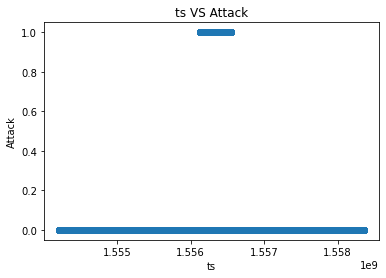

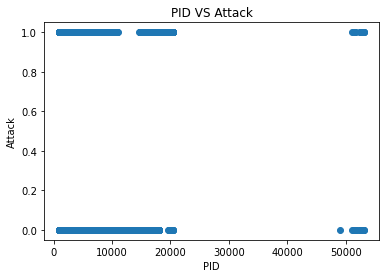

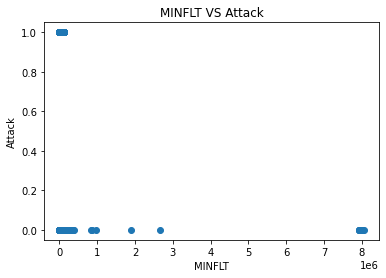

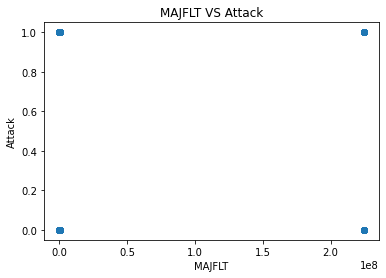

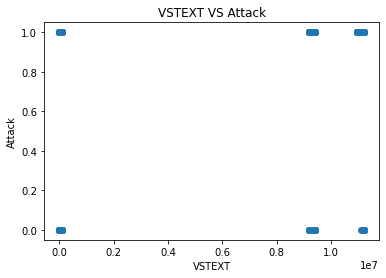

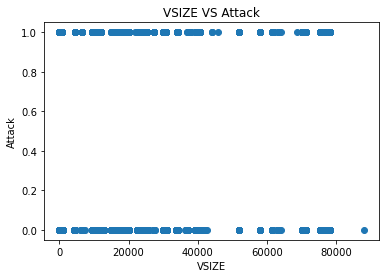

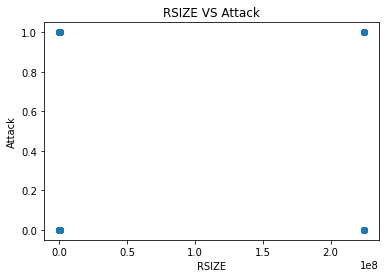

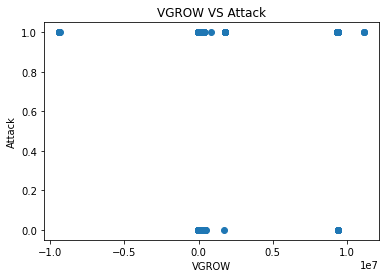

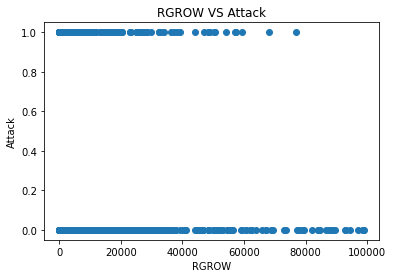

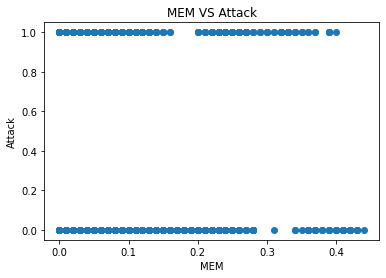

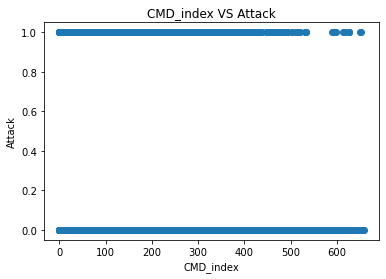

In [27]:
for column in [column for column in MnumericColumns if column != 'attack']:
    plt.xlabel(column)
    plt.ylabel('Attack')
    plt.title(column + ' VS Attack')
    plt.scatter(MemoryDf[column], MemoryDf.attack)
    plt.show()

We have already established how decision trees work, and so we can note that if a feature's values do not seem to share a relationship with attack, the relationship is not going to be particularly compelling for a decision tree algorithm. These are determined by identifying plots where there is no range or subset of feature values that seem to indicate the presence or absence of an attack. Immediately, we can see **features that do NOT seem to be a strong indicator of the label value**. :


- `ts`: While this variable reliably identifies a subset of values for which attacks seem to take place, this is simply a timestamp and so is not 
generalisable.

- `PID`
- `MAJFLT`
- `VSTEXT`
- `VSTEXT`
- `VSIZE`
- `RSIZE`
- `MEM`

**Features that DO seem to be a strong indicator of the label value**:

- `MINFLT`: Feature values close to its maximum of 8,000,000 seem to universally indicate a non-attack
- `VGROW`: Negative feature values seem to universally indicate an attack
- `RGROW`: Feature values above 60,000 may indicate a non-attack
- `CMD_index`: At values higher than 500, an attack seems unlikely but not impossible

Based on these observations, **I would select the following graphs to present to StopHacking**:

- `MINFLT` VS `attack`
- `VGROW` VS `attack`

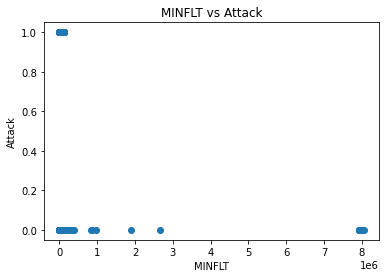

In [28]:
plt.xlabel('MINFLT')
plt.ylabel('Attack')
plt.title('MINFLT vs Attack')
plt.scatter(MemoryDf['MINFLT'],MemoryDf['attack'])
plt.show()

Here, it is easy to see that while it is difficult to label a process as attack or non-attack given a `MINFLT` value of 0, the same is not true for a `MINFLT` value of 8,000,000. While the former cannot be reliably classified, the latter is easily and universally classifiable as a non-attack. Roughly applying this logic to a decision tree, such a value would be accurately and reliably used to classify a process as a non-attack.

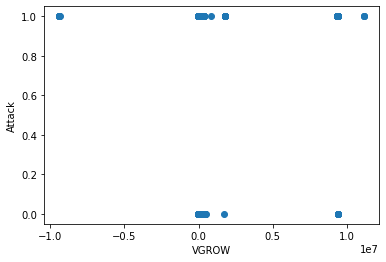

In [29]:
plt.xlabel('VGROW')
plt.ylabel('Attack')
plt.scatter(MemoryDf['VGROW'],MemoryDf['attack'])
plt.show()

Here, it is equally easy to see that a `VGROW` value lower than 0 reliably predicts an attack, whereas such a distinction cannot be made for values greater than or equal to 0, which could indicate either an attack or a non-attack. A combination of such features could be used for greater accuracy in detecting an attack. For example, a high `MINFLT` value coupled with a high `VGROW` value would likely be classified a non-attack, whereas a low `MINFLT` value coupled with a low `VGROW` value is likelier to be an attack. 

Predictions based on features such as these would only gain accuracy when combined with other features that also show certain patterns with regard to the presence of an attack, such as `RGROW`, and `MEM`, which also exhibit similar properties, but with a narrower range of values.

We now repeat the above process for the Process Dataframe:

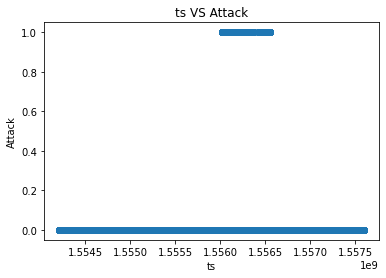

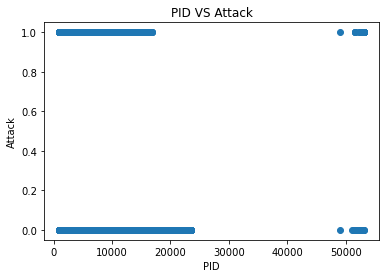

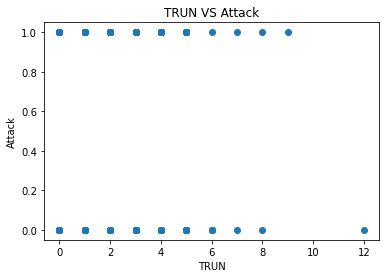

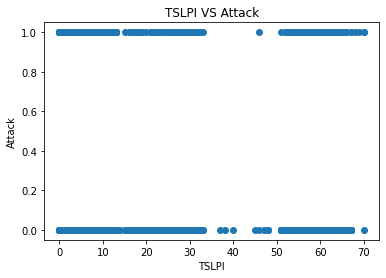

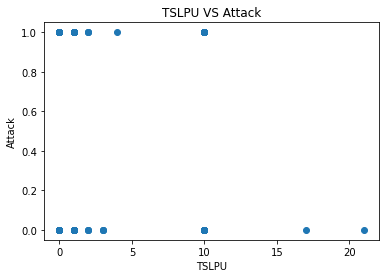

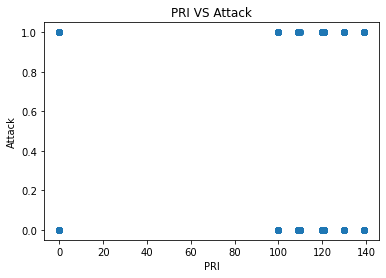

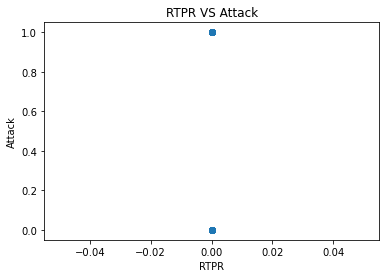

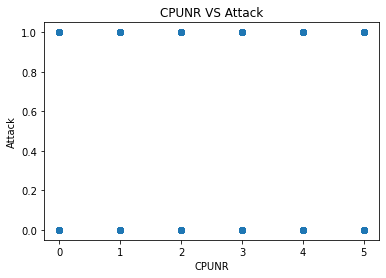

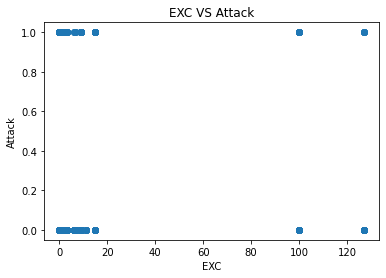

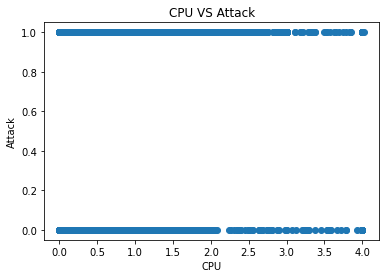

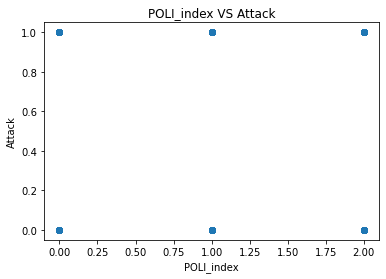

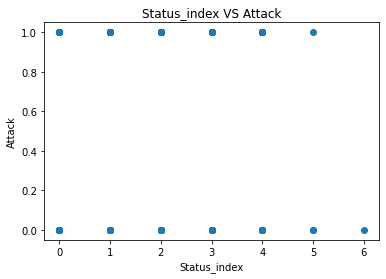

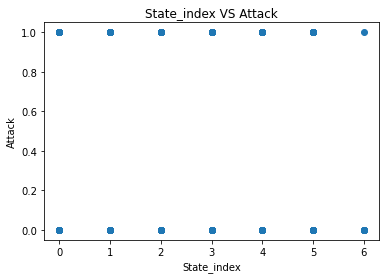

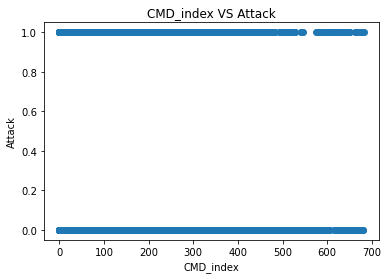

In [30]:
for column in [column for column in PnumericColumns if column != 'attack']:
    plt.xlabel(column)
    plt.ylabel('Attack')
    plt.title(column + ' VS Attack')
    plt.scatter(ProcessDf[column], ProcessDf.attack)
    plt.show()

We have already established how decision trees work, and so we can note that if a feature's values do not seem to share a relationship with attack, the relationship is not going to be particularly compelling for a decision tree algorithm. These are determined by identifying plots where there is no range or subset of feature values that seem to indicate the presence or absence of an attack. Immediately, we can see **features that do NOT seem to be a strong indicator of the label value**. :


- `ts`: While this variable reliably identifies a subset of values for which attacks seem to take place, this is simply a timestamp and so is not 
generalisable.
- `PID`
- `TSLPI`
- `PRI`
- `RTPR`
- `CPUNR`
- `EXC`
- `CPU`

**Features that DO seem to be a strong indicator of the label value**:

- `TRUN`: Feature values greater than ~9 seem to indicate a non-attack, and a value of 9 seems to indicate an attack
- `TSLPU`: Feature values greater than ~10 seem to indicate a non-attack
- `Status_Index`: An attack seems unlikely at a value of 6

Based on these observations, **I would select the following graphs to present to StopHacking**:

- `TRUN` VS `attack`
- `TSLPU` VS `attack`

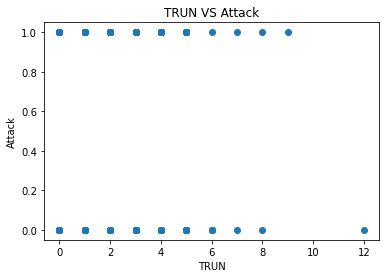

In [31]:
plt.xlabel('TRUN')
plt.ylabel('Attack')
plt.title('TRUN VS Attack')
plt.scatter(ProcessDf['TRUN'], ProcessDf.attack)
plt.show()

Here, we can note that a `TRUN` value of 12 always indicates a non-attack. We also see that a value of ~9 indicates an attack, but it in unclear whether this would be an entirely reliable estimator as this might represent only a single row where this is the case. It is also possible that the value of 12 represents an error in the data, or that it also represents a single row where this is the case.

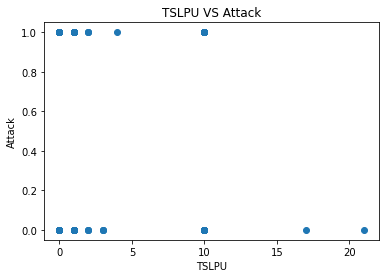

In [32]:
plt.xlabel('TSLPU')
plt.ylabel('Attack')
plt.title('TSLPU VS Attack')
plt.scatter(ProcessDf['TSLPU'], ProcessDf.attack)
plt.show()

Here, we can agian see that `TSLPU` values greater than 10 seem to universally indicate a non-attack, and that values smaller than 10 make it difficult to make such a determination. For the Process Dataframe, we can immediately note that we are not able to reliably tell when something is an attack. Instead, we are only able to reliably tell when something is NOT an attack, which is not as useful. Unfortunately, these are the only 2 features from the Process Dataframe that seem to share any sort of relationship with the `attack` label. 

We recall that in the Memory Dataframe, we were able to distinguish between attacks and non-attacks with only 2 features, but that there were also additional features which may have increased our accuracy. This is not a capability afforded to us by the Process Dataframe, meaning its related decision tree will likely not be as instrumental in detecting attacks.

To summarise the plots that demonstrated interesting relationships:
- Memory Dataframe:
    - `MINFLT` VS `attack`
    - `VGROW` VS `attack`
 

- Process Dataframe:
    - `TRUN` VS `attack`
    - `TSLPU` VS `attack`

# 2 - Feature Extraction & ML Training

## 2.1 - Preparing the training data and testing data
##  2.1.1

In [33]:
Mtrain, Mtest = Memory.randomSplit([0.8, 0.2], seed=42)
Ptrain, Ptest = Process.randomSplit([0.8, 0.2], seed=42)

In [34]:
# Verify that the splitting process went as expected
print ('Number of Rows in Memory: ', Memory.count())
print ('Number of Rows in Mtrain + Mtest: ', Mtrain.count(),'+', Mtest.count(),'=',Mtrain.count()+Mtest.count())
print ('Number of Rows in Mtrain / Number of Rows in Mtest: ', Mtrain.count()/Mtest.count())
print ('\nNumber of Rows in Process: ', Process.count())
print ('Number of Rows in Ptrain + Ptest: ', Ptrain.count(),'+', Ptest.count(),'=',Ptrain.count()+Ptest.count())
print ('Number of Rows in Ptrain / Number of Rows in Ptest: ', Ptrain.count()/Ptest.count())

Number of Rows in Memory:  2000000
Number of Rows in Mtrain + Mtest:  1600005 + 399995 = 2000000
Number of Rows in Mtrain / Number of Rows in Mtest:  4.00006250078126

Number of Rows in Process:  1927968
Number of Rows in Ptrain + Ptest:  1542231 + 385737 = 1927968
Number of Rows in Ptrain / Number of Rows in Ptest:  3.9981412205725664


## 2.1.2

In order to resample our data such that we only retain 20% of the rows where `attack`=1, and 40% of the rows where `attack`=0, we first need to determine how many such rows previously exist in our training data:

In [35]:
# Inspect our data for resampling
Mtrain.groupBy("attack").count().orderBy("attack").show()

+------+-------+
|attack|  count|
+------+-------+
|     0|1435753|
|     1| 164252|
+------+-------+



With 164,252 attacks and 1,435,753 non-attacks, we are interested in a refined Mtrain such that it includes:

- $164,252\times20\%\approx32,850$ attack rows, representing 20% of the rows where `attack`=1
- $32,850\times2=65,700$ non-attack rows, representing $\frac{65,700100\times}{1,435,753}\approx4.57\%$ of the rows where `attack`=0

Using `sampleBy`, we would need to specify these calculated percentages:

In [36]:
# Resample our data as per requirements
rebalancedMtrain = Mtrain.sampleBy("attack", fractions={0: 0.0457, 1: 0.2}, seed=42)
rebalancedMtrain.groupBy("attack").count().orderBy("attack").show()
Mtrain = rebalancedMtrain

+------+-----+
|attack|count|
+------+-----+
|     0|65767|
|     1|33121|
+------+-----+



With 232,901 attacks and 1,309,330 non-attacks, we are interested in a refined Mtrain such that it includes:

- $232,901\times20\%\approx46,580$ attack rows, representing 20% of the rows where `attack`=1
- $46,580\times2=93,160$ non-attack rows, representing $\frac{93,160\times100}{1,309,330}\approx7.12\%$ of the rows where `attack`=0

Using `sampleBy`, we would need to specify these calculated percentages:

In [37]:
rebalancedPtrain = Ptrain.sampleBy("attack", fractions={0: 0.0712, 1: 0.2}, seed=42)
rebalancedPtrain.groupBy("attack").count().orderBy("attack").show()
Ptrain = rebalancedPtrain

+------+-----+
|attack|count|
+------+-----+
|     0|93141|
|     1|46925|
+------+-----+



We have successfully rebalanced our data to conform to the requirements specified in Section 2.1.2

## 2.2 - Preparing features, labels, and models
## 2.2.1

Based on discussions above, I would hypothesise that the following features would be the most useful:

- Memory Dataframe:
    - `MINFLT`
    - `VGROW`
    - `RGROW`
    - `MEM`
    - `CMD_index`

- Process Dataframe:
    - `TRUN`
    - `TSLPU`
    - `PID`
    - `Status_index`

We must reiterate that after internally observing the plots derived from Process, there do not seem to be many variables that will reliably allow a decision tree to create the decision rules that it would ideally use to classify a process into attack or non-attack. Here, I would hypothesis that a Decision Tree based on the Process Dataframe would not be very accurate or useful in predicting an attack.

According to our textbook, *Learning Spark: Lightning-Fast Data Analytics*, Decision Trees are "scale-invariant (i.e., standardizing or scaling the numeric features does not change the performance of the tree)." With this in mind, we can proceed to identify transformers and estimators for our features:

- `StringIndexer`: Required to convert categorical variables into numbers (already implemented prior to visualisation)
- `VectorAssembler`: Required to create feature vectors to pass into our models as `inputCols`

In this situation, we would not use `OneHotEnconder`, because a Decision Tree does not take into account the numeric relationships introduced between the different categories within a feature. If we were performing regression rather than classification, we would use `OneHotEncoder`.

## 2.2.2

In [38]:
# Once again StringIndex our data to be on the safe side
MstringColumns = [column for column in Memory.columns if Memory.select(column).dtypes[0][1] == 'string' and column not in ['attack','type']]
PstringColumns = [column for column in Process.columns if Process.select(column).dtypes[0][1] == 'string' and column not in ['attack','type']]

#Define the input columns
MoutputCols=[f'{x}_index' for x in MstringColumns]
PoutputCols=[f'{x}_index' for x in PstringColumns]

Mindexer = StringIndexer(inputCols=MstringColumns, outputCols=MoutputCols)
MtrainIndexed = Mindexer.fit(Mtrain).transform(Mtrain)
MtestIndexed = Mindexer.fit(Mtest).transform(Mtest)

Pindexer = StringIndexer(inputCols=PstringColumns, outputCols=PoutputCols)
PtrainIndexed = Pindexer.fit(Ptrain).transform(Ptrain)
PtestIndexed = Pindexer.fit(Ptest).transform(Ptest)

# Rename column to be able to calculate evaluation statistics later
MtrainIndexed = MtrainIndexed.withColumnRenamed('attack','label')
MtestIndexed = MtestIndexed.withColumnRenamed('attack','label')

PtrainIndexed = PtrainIndexed.withColumnRenamed('attack','label')
PtestIndexed = PtestIndexed.withColumnRenamed('attack','label')

In [39]:
# Lists of the features I have selected
Mfeatures = ['MINFLT','VGROW','RGROW','MEM','CMD_index']
Pfeatures = ['TRUN','TSLPU','PID','Status_index']

## 2.2.3 - 2.3.2

In [84]:
# Assemble features into a vector
Massembler = VectorAssembler(inputCols=Mfeatures, outputCol='features')

# Initialise decision tree and GBT classifiers
MdecisionTree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
MgbTree = GBTClassifier(maxIter=100, maxDepth=10, featuresCol = 'features', labelCol='label', seed=42)

# 2 pipelines; one for each classifier
Mpipeline1 = Pipeline(stages=[Massembler, MdecisionTree])
Mpipeline2 = Pipeline(stages=[Massembler, MgbTree])

# set .setMaxBins to abnormally an high number to avoid errors
MdecisionTree.setMaxBins(5000)
MgbTree.setMaxBins(5000)

# Fit the classifiers
Mdt = Mpipeline1.fit(MtrainIndexed)
Mgbt = Mpipeline2.fit(MtrainIndexed)

# Transform test data
MdtPredictions = Mdt.transform(MtestIndexed)
MgbtPredictions = Mgbt.transform(MtestIndexed)

# Get confusion matrices for each classifier
print('DECISION TREE: ')
MdtPredictions.select('label','prediction').groupBy('label','prediction').count().show()

print('GRADIENT BOOSTED DECISION TREE: ')
MgbtPredictions.select('label','prediction').groupBy('label','prediction').count().show()

DECISION TREE: 
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 24182|
|    0|       0.0|315932|
|    1|       1.0| 17189|
|    0|       1.0| 42692|
+-----+----------+------+

GRADIENT BOOSTED DECISION TREE: 
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 17733|
|    0|       0.0|250574|
|    1|       1.0| 23638|
|    0|       1.0|108050|
+-----+----------+------+



In [121]:
# Assemble features into a vector
Passembler = VectorAssembler(inputCols=Pfeatures, outputCol='features')
PTassembled = Passembler.transform(PtrainIndexed)

# Initialise decision tree and GBT classifiers
PdecisionTree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
PgbTree = GBTClassifier(maxIter=100, maxDepth=10, featuresCol = 'features', labelCol='label', seed=42)

# 2 pipelines; one for each classifier
Ppipeline1 = Pipeline(stages=[Passembler, PdecisionTree])
Ppipeline2 = Pipeline(stages=[Passembler, PgbTree])

# set .setMaxBins to abnormally an high number to avoid errors
PdecisionTree.setMaxBins(5000)
PgbTree.setMaxBins(5000)

# Fit the classifiers
Pdt = Ppipeline1.fit(PtrainIndexed)
Pgbt = Ppipeline2.fit(PtrainIndexed)

# Transform test data
PdtPredictions = Pdt.transform(PtestIndexed)
PgbtPredictions = Pgbt.transform(PtestIndexed)

# Get confusion matrices for each classifier
print('DECISION TREE: ')
PdtPredictions.select('label','prediction').groupBy('label','prediction').count().show()

print('GRADIENT BOOSTED DECISION TREE: ')
PgbtPredictions.select('label','prediction').groupBy('label','prediction').count().show()

DECISION TREE: 
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 29798|
|    0|       0.0|293545|
|    1|       1.0| 28665|
|    0|       1.0| 33729|
+-----+----------+------+

GRADIENT BOOSTED DECISION TREE: 
+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       0.0| 25679|
|    0|       0.0|293784|
|    1|       1.0| 32784|
|    0|       1.0| 33490|
+-----+----------+------+



## 2.3.3

In [122]:
# Define a function to help evaluate model performance

modelDictionary = {MdtPredictions: 'MEMORY - DECISION TREE',
                  MgbtPredictions: 'MEMORY - GRADIENT BOOSTED DECISION TREE',
                  PdtPredictions: 'PROCESS - DECISION TREE',
                  PgbtPredictions: 'PROCESS - GRADIENT BOOSTED DECISION TREE'}

def evaluator(model):
    
    name = modelDictionary[model]
    
    print ('\n')
    print (name)

    # Format the predictions dataframe; convert columns to double, convert DataFrame to RDD
    model = model.select('label','prediction').withColumn('label',model.label.cast(DoubleType())).rdd
    
    # Initialise libraries to help with model evaluation
    MultiClass = MulticlassMetrics(model)
    Binary = BinaryClassificationMetrics(model)
    
    AUC = Binary.areaUnderROC
    Accuracy = MultiClass.accuracy
    
    Recall0 = MultiClass.recall(0)
    Recall1 = MultiClass.recall(1)
    
    Precision0 = MultiClass.precision(0)
    Precision1 = MultiClass.precision(1)
   
    # Also learn FPR and TPR to plot the ROC with
    FPR0 = MultiClass.falsePositiveRate(0.0)
    FPR1 = MultiClass.falsePositiveRate(1.0)
    
    TPR0 = MultiClass.truePositiveRate(0.0)
    TPR1 = MultiClass.truePositiveRate(1.0)
    
    print ('\nAUC: ',AUC)
    print ('Accuracy: ',Accuracy)
    
    print ('\nRecall of Label 0 (Non-Attack): ',Recall0)
    print ('Recall of Label 1 (Attack): ',Recall1)
    
    print ('\nPrecision of Label 0 (Non-Attack): ',Precision0)
    print ('Precision of Label 1 (Attack): ',Precision1)
    
    print('\nROC CURVE:\n')
    
    x = [FPR0,FPR1]
    y = [TPR0,TPR1]
    
    # Plot the ROC
    plt.plot(x,y)
    plt.title(name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [126]:
Passembled = Passembler.transform(PtrainIndexed)
Pdt1 = PdecisionTree.fit(Passembled)
Pdt2 = Pdt1.transform(PtestIndexed)

IllegalArgumentException: features does not exist. Available: ts, PID, TRUN, TSLPI, TSLPU, POLI, NICE, PRI, RTPR, CPUNR, Status, EXC, State, CPU, CMD, label, type, POLI_index, State_index, Status_index, CMD_index, NICE_index

In [125]:
Pdt2

AttributeError: 'DecisionTreeClassificationModel' object has no attribute 'select'

In [46]:
trainingSummary = Pdt.stages[-2].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

AttributeError: 'VectorAssembler' object has no attribute 'summary'

## 2.3.4

In [ ]:
models = [Mdt,Mgbt,Pdt,Pgbt]
modelNames = ['MEMORY - DECISION TREE','MEMORY - GRADIENT BOOSTED DECISION TREE','PROCESS - DECISION TREE','PROCESS - GRADIENT BOOSTED DECISION TREE']

featuresDictionary = {Mdt:Mfeatures,
                     Mgbt:Mfeatures,
                     Pdt:Pfeatures,
                     Pgbt:Pfeatures}

# Get most important features
for model in models:
    print('\n')
    print(modelNames[models.index(model)])
    print(pd.DataFrame(list(zip(featuresDictionary[model],model.stages[-1].featureImportances))).sort_values(by=1,ascending=False))
    print('\n')

We can now see the top-most important features for each Dataframe and classifier. For Process, I was only able to select 4 features, as the visualisations did not demonstrate any noticeable separability in other features.

In this situation, since our priority is to identify attacks, it would make sense to primarily consider Recall so that we can know how many of the true attacks were correctly identified as attacks. Having decided on this, we can see that we have quite a poor rate of Recall on Label 1 across all 4 categories.

- MEMORY: MEMORY - DECISION TREE has the highest value for every included statistic.

- PROCESS: ROCESS - GRADIENT BOOSTED DECISION TREE has the highest value for every included statistic.

ROC Curves for the two are included below in the following cells:

In [ ]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.show()

In [ ]:
# Define a function to help evaluate model performance

modelDictionary = {MdtPredictions: 'MEMORY - DECISION TREE',
                  MgbtPredictions: 'MEMORY - GRADIENT BOOSTED DECISION TREE',
                  PdtPredictions: 'PROCESS - DECISION TREE',
                  PgbtPredictions: 'PROCESS - GRADIENT BOOSTED DECISION TREE'}

def ROC(model):
    
    name = modelDictionary[model]
    print ('\n')
    print (name)

    # Format the predictions dataframe; convert columns to double, convert DataFrame to RDD
    model = model.select('label','prediction').withColumn('label',model.label.cast(DoubleType())).rdd
    
    # Initialise libraries to help with model evaluation
    MultiClass = MulticlassMetrics(model)
    Binary = BinaryClassificationMetrics(model)
   
    # Also learn FPR and TPR to plot the ROC with
    FPR0 = MultiClass.falsePositiveRate(0.0)
    FPR1 = MultiClass.falsePositiveRate(1.0)
    
    TPR0 = MultiClass.truePositiveRate(0.0)
    TPR1 = MultiClass.truePositiveRate(1.0)
    
    print('\nROC CURVE:\n')
    
    x = [FPR0,FPR1]
    y = [TPR0,TPR1]
    
    # Plot the ROC
    plt.plot(x,y)
    plt.title(name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
for model in [MdtPredictions, PgbtPredictions]:
    ROC(model)

`ts` should **NOT** be included in this model, mainly because the metadata file informs us that it represents a timestamp. We have already seen in our visualisations that `attack` is highly dependent on `ts`, as the data includes a clearly visible set of times when the system was being consecutively attacked. If the decision tree were allowed to base its decisions on `ts`, it would split on `ts`, and be able to accurately determine (on the test set) whether or not an attack was taking place.

Unfortunately, this is not generalisable. The model will never see those timestamps again, and the model will therefore be unable to account for future times. So, including `ts` would mean that the model would see ~100% accuracy on the training and test data, but will be far less accurate on future, unseen data.



`ts` should not be included in the model because it is a time-stamp, and is not generalisable; It will never repeat, and so any rule-based prediction on its value will only be accurate for the training dataset, and not future data.

## 2.3.5

In [ ]:
Memory.groupBy("attack").count().orderBy("attack").show()
Process.groupBy("attack").count().orderBy("attack").show()

We want a new Mtrain dataset such that:

- There are 205,623 attack rows (100% of attack rows)
- There are 411,246 non-attack rows (23% of non-attack rows)

We want a new Ptrain dataset such that:
- There are 291,634 attack rows (100% of attack rows)
- There are 583,268 non-attack rows (36% of non-attack rows)

I am unclear on this, but I assume that all data not included in these new training datasets are part of the testing dataset.

In [ ]:
Mtrain2 = Memory.sampleBy("attack", fractions={0: 0.23, 1: 1}, seed=42)
Ptrain2 = Process.sampleBy("attack", fractions={0: 0.36, 1: 1}, seed=42)

In [ ]:
#Mtest2 = Memory.join(Mtrain2,("ts"),"leftanti")
#Ptest2 = Process.join(Ptrain2,("ts"),"leftanti")

In [ ]:
MstringColumns = [column for column in Memory.columns if Memory.select(column).dtypes[0][1] == 'string' and column not in ['attack','type']]
PstringColumns = [column for column in Process.columns if Process.select(column).dtypes[0][1] == 'string' and column not in ['attack','type']]

#Define the input columns
MoutputCols=[f'{x}_index' for x in MstringColumns]
PoutputCols=[f'{x}_index' for x in PstringColumns]

Mindexer = StringIndexer(inputCols=MstringColumns, outputCols=MoutputCols)
MtrainIndexed = Mindexer.fit(Mtrain2).transform(Mtrain2)
#MtestIndexed = Mindexer.fit(Mtest2).transform(Mtest2)

Pindexer = StringIndexer(inputCols=PstringColumns, outputCols=PoutputCols)
PtrainIndexed = Pindexer.fit(Ptrain2).transform(Ptrain2)
#PtestIndexed = Pindexer.fit(Ptest2).transform(Ptest2)

MtrainIndexed = MtrainIndexed.withColumnRenamed('attack','label')
#MtestIndexed = MtestIndexed.withColumnRenamed('attack','label')

PtrainIndexed = PtrainIndexed.withColumnRenamed('attack','label')
#PtestIndexed = PtestIndexed.withColumnRenamed('attack','label')

In [ ]:
Massembler = VectorAssembler(inputCols=Mfeatures, outputCol='features')

MdecisionTree2 = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
MgbTree2 = GBTClassifier(maxIter=100, maxDepth=10, featuresCol = 'features', labelCol='label', seed=42)

Mpipeline12 = Pipeline(stages=[Massembler, MdecisionTree])
Mpipeline22 = Pipeline(stages=[Massembler, MgbTree])

MdecisionTree2.setMaxBins(5000)
MgbTree2.setMaxBins(5000)
Mdt2 = Mpipeline12.fit(MtrainIndexed)
Mgbt2 = Mpipeline22.fit(MtrainIndexed)

MdtPredictions = Mdt2.transform(MtestIndexed)
MgbtPredictions = Mgbt2.transform(MtestIndexed)

print('DECISION TREE: ')
MdtPredictions.select('label','prediction').groupBy('label','prediction').count().show()

print('GRADIENT BOOSTED DECISION TREE: ')
MgbtPredictions.select('label','prediction').groupBy('label','prediction').count().show()

In [ ]:
Passembler = VectorAssembler(inputCols=Pfeatures, outputCol='features')

PdecisionTree2 = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
PgbTree2 = GBTClassifier(maxIter=100, maxDepth=10, featuresCol = 'features', labelCol='label', seed=42)

Ppipeline12 = Pipeline(stages=[Passembler, PdecisionTree])
Ppipeline22 = Pipeline(stages=[Passembler, PgbTree])

PdecisionTree2.setMaxBins(5000)
PgbTree2.setMaxBins(5000)
Pdt2 = Ppipeline12.fit(PtrainIndexed)
Pgbt2 = Ppipeline22.fit(PtrainIndexed)

PdtPredictions = Pdt2.transform(PtestIndexed)
PgbtPredictions = Pgbt2.transform(PtestIndexed)

print('DECISION TREE: ')
PdtPredictions.select('label','prediction').groupBy('label','prediction').count().show()

print('GRADIENT BOOSTED DECISION TREE: ')
PgbtPredictions.select('label','prediction').groupBy('label','prediction').count().show()

In [ ]:
# Define a function to help evaluate model performance

modelDictionary = {MdtPredictions: 'MEMORY - DECISION TREE',
                  MgbtPredictions: 'MEMORY - GRADIENT BOOSTED DECISION TREE',
                  PdtPredictions: 'PROCESS - DECISION TREE',
                  PgbtPredictions: 'PROCESS - GRADIENT BOOSTED DECISION TREE'}

def evaluator(model):
    
    name = modelDictionary[model]
    
    print ('\n')
    print (name)

    # Format the predictions dataframe; convert columns to double, convert DataFrame to RDD
    model = model.select('label','prediction').withColumn('label',model.label.cast(DoubleType())).rdd
    
    # Initialise libraries to help with model evaluation
    MultiClass = MulticlassMetrics(model)
    Binary = BinaryClassificationMetrics(model)
    
    AUC = Binary.areaUnderROC
    Accuracy = MultiClass.accuracy
    
    Recall0 = MultiClass.recall(0)
    Recall1 = MultiClass.recall(1)
    
    Precision0 = MultiClass.precision(0)
    Precision1 = MultiClass.precision(1)
   
    # Also learn FPR and TPR to plot the ROC with
    FPR0 = MultiClass.falsePositiveRate(0.0)
    FPR1 = MultiClass.falsePositiveRate(1.0)
    
    TPR0 = MultiClass.truePositiveRate(0.0)
    TPR1 = MultiClass.truePositiveRate(1.0)
    
    print ('\nAUC: ',AUC)
    print ('Accuracy: ',Accuracy)
    
    print ('\nRecall of Label 0 (Non-Attack): ',Recall0)
    print ('Recall of Label 1 (Attack): ',Recall1)
    
    print ('\nPrecision of Label 0 (Non-Attack): ',Precision0)
    print ('Precision of Label 1 (Attack): ',Precision1)
    
    print('\nROC CURVE:\n')
    
    x = [FPR0,FPR1]
    y = [TPR0,TPR1]
    
    # Plot the ROC
    plt.plot(x,y)
    plt.title(name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [ ]:
for model in [MdtPredictions, MgbtPredictions, PdtPredictions, PgbtPredictions]:
    evaluator (model)

- Memory: The better model is our second Decision Tree, on the rebalaned training data
- Process: The better model is our second Gradient Boosted Decision Tree, on the rebalanced training data

They are saved:

In [ ]:
PgbTree2.save('ProcessGBT2')
MdecisionTree2.save('MemoryDT2')